In [22]:
import gensim
from IPython.display import Image
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)

In [2]:
from sklearn.datasets import fetch_20newsgroups

# we take 2 news groups:
# 1) rec : recreational activities (entertainment)
# 2) sci : science
categories = [
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
]

# remove the following context, we only need the content
remove = ('headers', 'footers', 'quotes')

# after fetching the data
# content will store in newsgroups.data
# label will store in newsgroups.target
newsgroups = fetch_20newsgroups(subset='all', categories=categories,
                                     shuffle=True, random_state=0,
                                     remove=remove)

In [3]:
print('#Data size: %s' % np.shape(newsgroups.data))
print('Labels: %s' % np.unique(newsgroups.target))

#Data size: 7931
Labels: [0 1 2 3 4 5 6 7]


In [4]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop('runners like running and thus they run'))

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[u'runner', 'like', u'run', u'thu', 'run']


In [5]:
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation


# preprocess the text
corpus = []
for text in newsgroups.data:
    corpus.append(tokenizer_stem_nostop(preprocessor(text)))

# size : embed dimension
# min_count : filter words without min frequency
# sg : 0 for CBOW; 1 for skip-gram
# negative : how many noise words should be drawn
%time model_w2v = gensim.models.Word2Vec(corpus, size=64, min_count=5, sg=1, negative=5, workers=2)

Using TensorFlow backend.


CPU times: user 22.7 s, sys: 28 ms, total: 22.7 s
Wall time: 11.5 s


In [7]:
display(model_w2v.most_similar('car'))
display(model_w2v.most_similar('american'))
display(model_w2v.most_similar('basebal'))

[(u'ford', 0.8176076412200928),
 (u'mustang', 0.7967401742935181),
 (u'nissan', 0.7952576875686646),
 (u'bike', 0.7919961214065552),
 (u'toyota', 0.7824968099594116),
 (u'audi', 0.778469443321228),
 (u'tauru', 0.7754430174827576),
 (u'truck', 0.7736278772354126),
 (u'camri', 0.7730960845947266),
 (u'sho', 0.7694990038871765)]

[(u'latin', 0.7448458671569824),
 (u'nativ', 0.7379274368286133),
 (u'nation', 0.7355138659477234),
 (u'competit', 0.7330318689346313),
 (u'entitl', 0.6995961666107178),
 (u'former', 0.69708651304245),
 (u'financi', 0.695411205291748),
 (u'consensu', 0.6874957084655762),
 (u'sex', 0.6806329488754272),
 (u'affili', 0.678200900554657)]

[(u'hockey', 0.8087467551231384),
 (u'footbal', 0.8064682483673096),
 (u'fan', 0.802107572555542),
 (u'basketbal', 0.7743037939071655),
 (u'brave', 0.7649409174919128),
 (u'enjoy', 0.758629560470581),
 (u'roster', 0.7545195817947388),
 (u'soccer', 0.7541965842247009),
 (u'aaa', 0.7462256550788879),
 (u'nhl', 0.7448275089263916)]

In [8]:
display(model_w2v.most_similar(positive=['america', 'bmw'], negative=['spain']))

[(u'owner', 0.792001485824585),
 (u'vw', 0.7547674179077148),
 (u'auto', 0.7486371994018555),
 (u'motorcycl', 0.7448223829269409),
 (u'own', 0.7314728498458862),
 (u'nissan', 0.7178159952163696),
 (u'dealership', 0.7170982956886292),
 (u'toyota', 0.7167567014694214),
 (u'boxer', 0.7157037854194641),
 (u'mustang', 0.7135183811187744)]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# for simplicity, we only take 512 features
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=512, sublinear_tf=True, 
                             max_df=0.5, preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)

X = vectorizer.fit_transform(newsgroups.data).toarray()
y = (newsgroups.target > 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# the dictionary map from word to feature index
dictionary = vectorizer.vocabulary_

# construct inverse_dictionary from feature index to dictionary
inverse_dictionary = {v: k for k, v in dictionary.items()}

In [13]:
def tfidf_word2vec_transform(model_w2v, embed_dim, inv_dic_tfidf, score_tfidf):
    tfidf_word2vec = np.zeros((score_tfidf.shape[0], embed_dim))
    for i in range(score_tfidf.shape[0]):
        doc_word2vec = np.zeros(embed_dim)
        for j in range(score_tfidf.shape[1]):
            doc_word2vec += score_tfidf[i, j] * model_w2v[inv_dic_tfidf[j]]
        tfidf_word2vec[i, :] = doc_word2vec
    return tfidf_word2vec

X_train_w2v = tfidf_word2vec_transform(model_w2v, 64, inverse_dictionary, X_train)
X_test_w2v = tfidf_word2vec_transform(model_w2v, 64, inverse_dictionary, X_test)

In [26]:
X_train_w2v[0]

array([ 0.41058146,  1.16992539, -0.54894748, -1.79961131, -0.35598106,
       -0.86564943,  0.33669829, -1.34908469, -0.29955901, -0.34102699,
        0.75765617, -0.18391607, -0.50561467, -1.087518  , -0.3385556 ,
        0.27133455, -0.5293879 , -0.04671408,  2.45314048, -0.46116331,
       -1.14009218, -0.10810752,  0.35553575,  1.2123351 ,  0.38534506,
        1.05823985, -0.10183711,  0.44092733,  0.3154994 , -0.77909755,
        1.21425244,  0.83364241,  0.87269434,  2.4830182 , -0.61685819,
        0.51340503, -0.50618246, -2.16490776, -0.01261099, -2.12627963,
       -1.56969479, -1.43095485, -1.01507289, -0.42928434,  1.16558249,
       -1.58090102, -1.34407029, -0.10722516,  0.51947929,  0.69150414,
        1.16724647, -1.60215616, -0.17482791,  0.72186637, -0.58711291,
        1.00358356,  1.12708677,  0.668967  ,  1.55330493, -1.54186796,
        0.5957557 ,  1.19417947,  1.1637022 , -0.5058592 ])

In [14]:
def gen_nn(input_dim=512, width=32, depth=2):
    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=width))
    model.add(Activation('relu'))
    for k in range(2, depth):
        model.add(Dense(output_dim=width))
        model.add(Activation('relu'))
    model.add(Dense(output_dim=1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [47]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0)
tb_callBack = TensorBoard(log_dir='/tmp/tensorflow_logs/cnn_example/experiment_keras', 
                         histogram_freq=0, write_graph=True, write_images=True)
model = gen_nn(input_dim=X_train_w2v.shape[1])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=32, input_dim=64)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [48]:
%time his = model.fit(X_train_w2v, y_train, \
                      nb_epoch=1000, \
                      batch_size=batch_size, \
                      validation_split=0.2, \
                      shuffle=True, verbose=0, \
                      callbacks=[early_stop, tb_callBack])

CPU times: user 1min 51s, sys: 4.71 s, total: 1min 56s
Wall time: 51.1 s



Test loss: 0.323
Test accuracy: 0.849


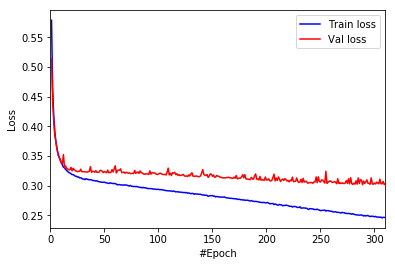

In [49]:
# evaluate trained model
score = model.evaluate(X_test_w2v, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
train_loss = his.history['loss']
val_loss = his.history['val_loss']

# visualize training history
plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
plt.xlim(0, len(train_loss))
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('./fig-nn-w2v-val.png', dpi=300)
plt.show()

In [45]:
len(model.get_weights()[1])

32